In [18]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (1).csv


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

In [20]:
df = pd.read_csv("train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:
print("Shape of dataset:", df.shape)

Shape of dataset: (891, 12)


In [22]:
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [23]:
df['Survived'].value_counts()

,count
Survived,
0,549
1,342


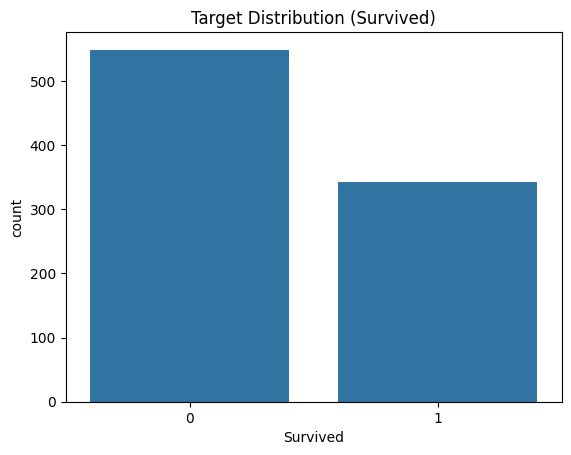

In [24]:
sns.countplot(x='Survived', data=df)
plt.title("Target Distribution (Survived)")
plt.show()

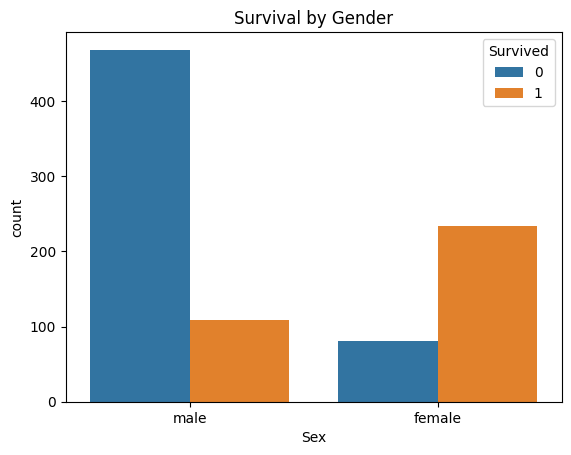

In [25]:
sns.countplot(x='Sex', hue='Survived', data=df)
plt.title("Survival by Gender")
plt.show()

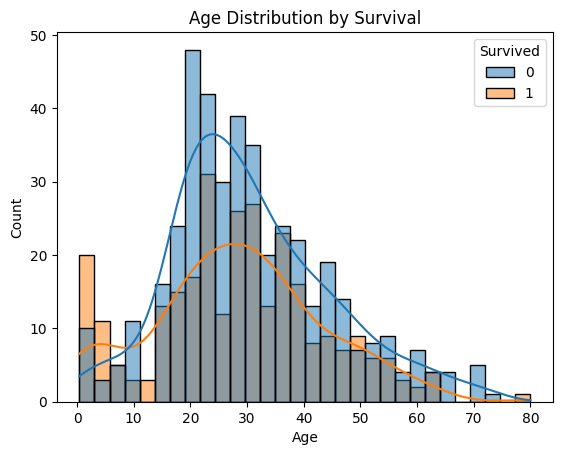

In [26]:
sns.histplot(data=df, x='Age', hue='Survived', bins=30, kde=True)
plt.title("Age Distribution by Survival")
plt.show()

In [27]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
target = 'Survived'

X = df[features]
y = df[target]

In [28]:
X['Age'].fillna(X['Age'].median(), inplace=True)
X['Fare'].fillna(X['Fare'].median(), inplace=True)

/tmp/ipython-input-3209931883.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['Age'].fillna(X['Age'].median(), inplace=True)
/tmp/ipython-input-3209931883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Age'].fillna(X['Age'].median(), inplace=True)
/tmp/ipython-input-3209931883.py:2: FutureWarning: A value is trying to be set on a

In [29]:
X = pd.get_dummies(X, columns=['Sex'], drop_first=True)

In [30]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [31]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', probability=True))
])

In [32]:
param_grid = {
    'svm__C': [0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(kernel='linear',
                                            probability=True))]),
             n_jobs=-1, param_grid={'svm__C': [0.01, 0.1, 1, 10, 100]},
             scoring='roc_auc')

In [33]:
print("Best C:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)

Best C: {'svm__C': 0.1}
Best CV ROC-AUC: 0.8279573688821337


In [34]:
y_val_proba = grid.best_estimator_.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_proba)

print("Validation ROC-AUC:", roc_auc)

Validation ROC-AUC: 0.7952569169960474


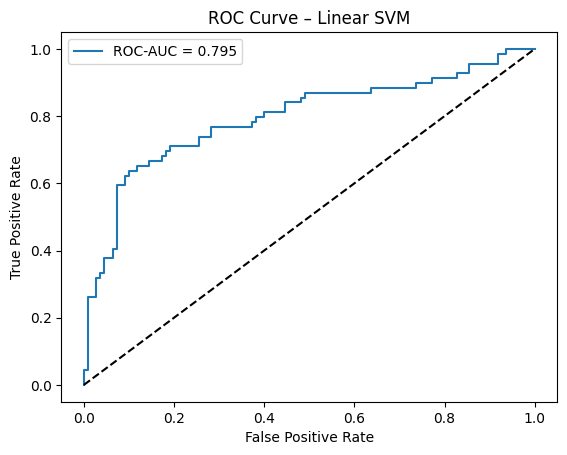

In [35]:
fpr, tpr, _ = roc_curve(y_val, y_val_proba)

plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Linear SVM")
plt.legend()
plt.show()